In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.styler import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.0001
lr2 = 0.0003
# model = Unet(device)
model = Unet().to(device)
cliploss = CLIPLoss(device)
# mseloss = torch.nn.MSELoss()
vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
for x in vgg.parameters():
    x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

In [3]:
file_cmp_outer = open("neo_cmp_outer.txt", "r")
loss_li = file_cmp_outer.readline()
loss_li = [float(x) for x in loss_li.split()]
if not loss_li:
    loss_li = [0]*200

cur_times = int(file_cmp_outer.readline())

In [4]:
def train(iteration1, iteration2, pic, source, target, path):
    input = pic

    # opt = optim.Adam(model.parameters(), lr=lr1)
    # for i in range(iteration1):
    #     opt.zero_grad()
    #     neo_pic = model(input)
    #     loss = mseloss(pic, neo_pic) * 1
    #     loss.backward()
    #     opt.step()
    #     pil = topil(neo_pic.squeeze(0).cpu())
    #     print("iter:", i + 1, "loss:", loss.item())
    #     if ((i + 1) % 50) == 0:
    #         pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    #
    #
    # torch.save(model,'unet.pth')


    # model = torch.load('unet.pth')

    pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    sch = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
    for i in range(iteration2):


        opt.zero_grad()
        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.forward_prior(pic, source, neo_pic, target)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda

        loss.backward()
        opt.step()
        sch.step()

        loss_li[i]+=(loss.item())

        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)

In [5]:
pil = Image.open(f"./source_pic/lena.png")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

C:\Users\win10\AppData\Local\Temp\ipykernel_34080\1855053385.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)


In [6]:
source = "photo"
# target = "pop art of night city"
# target = "starry night by Van Gogh"
# target = "the scream by Edvard Munch"
target = "Monet"
# target = "cyberpunk 2077"
# target = "Chinese Ink and wash painting"
path = "result3.jpg"

In [7]:
start = time.time()
train(200, 200, pic, source, target, path)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 10928.1728515625
iter: 2 loss: 10596.74609375
iter: 3 loss: 10426.134765625
iter: 4 loss: 10142.142578125
iter: 5 loss: 9946.2265625
iter: 6 loss: 9779.0966796875
iter: 7 loss: 9676.64453125
iter: 8 loss: 9432.7138671875
iter: 9 loss: 9385.7626953125
iter: 10 loss: 9269.83984375
iter: 11 loss: 9162.8095703125
iter: 12 loss: 9081.9580078125
iter: 13 loss: 8991.251953125
iter: 14 loss: 8944.591796875
iter: 15 loss: 8859.8271484375
iter: 16 loss: 8785.8994140625
iter: 17 loss: 8745.7900390625
iter: 18 loss: 8695.6015625
iter: 19 loss: 8665.751953125
iter: 20 loss: 8643.77734375
iter: 21 loss: 8568.58203125
iter: 22 loss: 8519.40234375
iter: 23 loss: 8500.7890625
iter: 24 loss: 8413.59765625
iter: 25 loss: 8363.8515625
iter: 26 loss: 8428.546875
iter: 27 loss: 8341.087890625
iter: 28 loss: 8311.71875
iter: 29 loss: 8242.994140625
iter: 30 loss: 8227.2734375
iter: 31 loss: 8233.9453125
iter: 32 loss: 8200.765625
iter: 33 loss: 8162.28173828125
iter: 34 loss: 8140.70458984375
i

In [8]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)


C:\Users\win10\AppData\Local\Temp\ipykernel_34080\1981065163.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)


In [9]:
with open(file = "neo_cmp_outer.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")
    file.write("\n")
    file.write(str(cur_times+1))

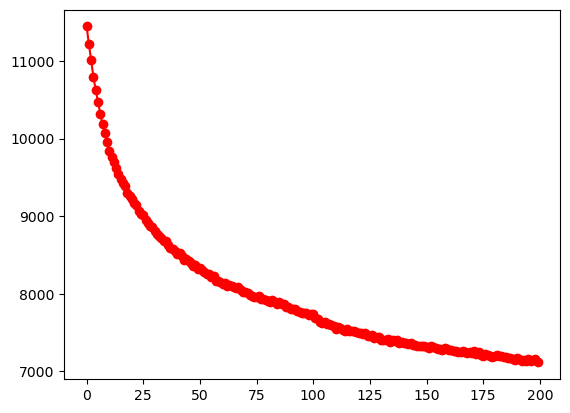

In [10]:
import matplotlib.pyplot as plt

x = [i for i in range(200)]
loss_li = [x/(cur_times+1) for x in loss_li]
plt.plot(x,loss_li,color="red",marker="o")

